# HS Spring 2020 Data Analysis

#### Importing libraries below:

In [1]:
import numpy as np
import scipy.stats as scs
import math
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from seaborn import heatmap

import re
import argparse
import logging

import os
# import glob
import sys
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

import gamework



### Utility Functions:

In [2]:
def q_summary_V1(numbers):
    '''
    This function takes in a list of numbers and uses numpy quantile functions
    to calculate quartile1, quartile2, and quartile3. This function also determines
    if there are any outliers in the input set.
    '''
    nums = sorted(numbers)
    q1 = np.quantile(nums, 0.25)
    q2 = np.quantile(nums, 0.5)
    q3 = np.quantile(nums, 0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    
    outs, safe = [], []
    for n in nums:
        if n >= lower and n <= upper:
            safe.append(n)
        else:
            outs.append(n)
    print('The following are outliers: {}'.format(outs))
    d = {'min':min(safe), 'q1':q1, 'q2':q2, 'q3':q3, 'max':max(safe)}
    return d

In [3]:
def generate_histograms_score_matchup(score_score, matchup_name, save_dir=None, ngames=390):
    '''
    This function takes as input a gamework.MatchupData() object and outputs into save_dir
    the histogram of the probability of the frequency of the number of turns per game.
    
    TODO - PUT THIS BACK TO NON-PDF (raw # games)
    
    '''
    d = {}

    for file in score_score.get_folders():
        match = gamework.MatchData(file, ngames)
        matchup_ = file.split('\\')[-1].strip('.csv')
        turns_groups = match.df.groupby('GAME_COUNTER').count()
        turns_groups.reset_index(inplace=True)
        d[matchup_] = turns_groups[['GAME_COUNTER', 'TURN_NO']]
        
    try:
        if save_dir is None:
            save_dir = 'C:\\Users\\Main\\Documents\\GitHub\\Sabber_Work_2019F\\thesis-output'
        root_output_dir = os.path.join(save_dir, 'num-turns-per-game')
        if not os.path.exists(root_output_dir):
            os.mkdir(root_output_dir)
            print('Made directory: {}'.format(root_output_dir))
    except:
        print('There was a problem making', root_output_dir)
        return
    try:
        output_dir = os.path.join(root_output_dir, matchup_name)
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
            print('Made directory: {}'.format(output_dir))
    except:
        print('There was a problem making', output_dir)
        return
    for matchup in d:
        
        output_file = os.path.join(output_dir, '{}-Hist.jpg'.format(matchup))
        bin_list = sorted(d[matchup]['TURN_NO'].unique())
        bin_list.append(max(bin_list) + 1)
        values_to_plot = d[matchup]['TURN_NO']
        mu = values_to_plot.mean()
        sigma = values_to_plot.std()

        n_, bins_, patches_ = plt.hist(values_to_plot, bins=bin_list, density=1)

        y = scs.norm.pdf(bins_, mu, sigma)

        plt.plot(bins_, y, 'r--')
        plt.title('PDF How Many Turns in Each Game for {}'.format(matchup))
        plt.xlabel('Number of Turns')
        plt.ylabel('Probability')
        plt.subplots_adjust(left=0.15)
        plt.savefig(output_file)
        print('Wrote histogram to: {}'.format(output_file))
        plt.clf()
        plt.close()
    return d

In [4]:
def find_num_turn_outliers(d):
    '''
    This function takes as input the dictionary object returned from generate_histograms,
    and determines if any of the matchups have outliers in the number of turns
    '''
    for matchup in d:
        print(matchup)
        vals_to_check = sorted(d[matchup]['TURN_NO'].values)
        print(q_summary_V1(vals_to_check))
        print('_________')

In [5]:
def get_val(df, m, v):
    try:
        x = df.loc[(v, m)]
        return x
    except:
        print('Check {} in df {}'.format(v, m))

def diff_in_means(df1, df2, m1, m2):
    x1 = get_val(df1, m1, 'Mean-Num-Turns')
    x2 = get_val(df2, m2, 'Mean-Num-Turns')
    if x1 is None or x2 is None:
        return
    dif = x1-x2
    if dif < 0:
        print('difference is negative')
        return dif
    return abs(dif)
    

def samp_stat(df1, df2, m1, m2, z):
    s1 = get_val(df1, m1, 'Std-Num-Turns')
    print(m1, s1)
    s2 = get_val(df2, m2, 'Std-Num-Turns')
    print(m2, s2)
    n1 = get_val(df1, m1, 'Num-Games')
    print(m1, n1)
    n2 = get_val(df2, m2, 'Num-Games')
    print(m2, n2)
    if s1 is None or s2 is None or n1 is None or n2 is None:
        return
    vss = math.sqrt((s1**2 / n1) + (s2**2 / n2))
    print('Std sampling distribution is', vss)
    return z* vss

In [6]:
def get_matchups_winrates(score_score, ngames=390):
    d = {}

    for file in score_score.get_folders():
        match = gamework.MatchData(file, ngames)
        matchup_ = file.split('\\')[-1].strip('.csv')
        player_names = matchup_.split('-')
        p1name = 'P1-{}'.format(player_names[0])
        p2name = 'P2-{}'.format(player_names[1])
        relevant_cols = ['TURN_NO', 'P1_HEALTH', 'P2_HEALTH', 'GAME_COUNTER']
        p1_wins = match.df.loc[(match.df['P2_HEALTH']<=0)][relevant_cols]
        p2_wins = match.df.loc[(match.df['P1_HEALTH']<=0)][relevant_cols]
        
        p1_n_wins = p1_wins.shape[0]
        p2_n_wins = p2_wins.shape[0]
        
        p1_wr = p1_n_wins/ngames
        p2_wr = p2_n_wins/ngames
        
        
        d[matchup_] = {p1name:{'Wins':p1_wins, 'NumWins':p1_n_wins, 'Winrate':p1_wr }, 
                       p2name:{'Wins':p2_wins, 'NumWins':p2_n_wins, 'Winrate':p2_wr}}
    return d

In [7]:
def get_winrates_for_matchup_asframe(score_score_wins):
    p1list = []
    p2list = []
    for key in score_score_wins:
        player_names = key.split('-')
        p1name = 'P1-{}'.format(player_names[0])
        p2name = 'P2-{}'.format(player_names[1])
        p1list.append(p1name)
        p2list.append(p2name)
        print(key, '\t', score_score_wins[key][p1name]['Winrate'])
    p1_unique = pd.Series(p1list).unique()
    p2_unique = pd.Series(p2list).unique()
    wrdf = pd.DataFrame(columns=p2_unique, index=p1_unique)
    for key in score_score_wins:
        player_names = key.split('-')
        p1name = 'P1-{}'.format(player_names[0])
        p2name = 'P2-{}'.format(player_names[1])
        wrdf.loc[p1name, p2name] = score_score_wins[key][p1name]['Winrate']
    return wrdf

In [8]:
def get_cleaned_match_df(folder):
    df = pd.read_csv(folder, index_col=0)
    player_names = df['CURRENT_PLAYER'].unique()
    p1, p2 = '', ''
    for pn in player_names:
        if 'P1' in pn:
            p1 = pn
        else:
            p2 = pn
    df.loc[df['CURRENT_PLAYER'] == p1, 'CURRENT_PLAYER'] = 1
    df.loc[df['CURRENT_PLAYER'] == p2, 'CURRENT_PLAYER'] = 2
    df.loc[:, 'CURRENT_PLAYER'] = df.loc[:, 'CURRENT_PLAYER'].astype(int)
    return df

In [9]:
def get_games_min_num_turns(df):
    min_n_turns = df.groupby('GAME_COUNTER').count()['TURN_NO'].min()
    print('min_n_turns is:', min_n_turns)
    df_games_minturns = df.loc[(df['TURN_NO'].isin(range(0, min_n_turns+1)))]
    # df_games_min8.loc[(df_games_min['TURN_NO']>min_n_turns)]
    return df_games_minturns

In [25]:
def get_games_atleast_num_turns(df, nturns):
    temp = df.groupby('GAME_COUNTER').max().reset_index()
    find_games = df.loc[(df['TURN_NO']>=nturns)][['TURN_NO', 'GAME_COUNTER']]
    df_games = df.loc[(df['GAME_COUNTER'].isin(find_games['GAME_COUNTER']))]
    return df_games

In [10]:
def get_featurevector_gameset(df, suppress=True):
    num_turns = int(df.shape[0]/df['GAME_COUNTER'].max())
    cols = list(df.iloc[:, :-1].columns) # take out the GAME_COUNTER column
    all_cols = []
    for i in range(num_turns):
        for col in cols:
            all_cols += ['{}-{}'.format(col, i)]
    
    df_trans = pd.DataFrame(df.iloc[:, :-1].values.reshape(df['GAME_COUNTER'].max(), len(all_cols)), columns=all_cols)

    if not suppress:
        for dataT in df_trans.dtypes:
            print(dataT, end="\t")
        
    return df_trans

In [111]:
def gameto_featurevectors(df):
    '''
    df - DataFrame which is the games after getting those which are at least N turns in length
        from the get_games_atleast_num_turns() function
        
    #this version fills in 0s when making the featurevector set for one game
    '''
    num_fvs = len(df['GAME_COUNTER'].unique()) #unmber of feature vectors
    highest_turncount = df['TURN_NO'].max()
    stats = df.iloc[:, :-1]
    ncols = stats.shape[1]
    newshape = (num_fvs, highest_turncount*ncols)
    
    cols = list(stats.columns)
    all_cols = []
    for i in range(1, highest_turncount+1):
        for col in cols:
            all_cols += ['{}-{}'.format(col, i)]

    games_for_fv = []
    current_row = []
    turn_counter = 0
    for index, row in stats.iterrows():
        if row['TURN_NO'] < turn_counter:
            while len(current_row) != newshape[1]:
                current_row.append(0)
            games_for_fv.append(current_row)
            current_row = []
        turn_counter = row['TURN_NO']
        current_row += list(row.values)
    while len(current_row) != newshape[1]:
        current_row.append(0)
    games_for_fv.append(current_row)
    #print('Number of feature vectors')
    for row in games_for_fv:
        if len(row) != newshape[1]:
            print('ERROR', games_for_fv.index(row))
            return
    return pd.DataFrame(games_for_fv, columns = all_cols)

In [11]:
def get_principal_components(df, ncomp=2):
    data_scaled = pd.DataFrame(preprocessing.scale(df),columns = df.columns)
    pca = PCA(n_components=ncomp)
    projected_data = pca.fit_transform(data_scaled)
    print('Explained Variance Ratio:\n{}'.format(pca.explained_variance_ratio_))
    print('Singular Values:\n{}'.format(pca.singular_values_))
    pc_1_2 = pd.DataFrame(pca.components_,columns=data_scaled.columns,index = ['PC-1','PC-2'])
    pc_1_2_T = pc_1_2.transpose()
    pc_1_2_T.sort_values('PC-1', inplace=True)
    pc_1_2_T['PC-1-ABS'] = pc_1_2_T['PC-1'].abs()
    pc_1_2_T['PC-2-ABS'] = pc_1_2_T['PC-2'].abs()
    return pc_1_2_T, projected_data

In [12]:
def get_winrates_heatmap_formatchup(mm_sdf, s1, s2, ppath = None, colm=None):
    '''
    mm_sdf - DF returned with the stats for all games in a given matchup
    s1 - scoring function 1
    s2 - scoring function 2
    '''
    mmp1_winratess = mm_sdf.iloc[6,:]
    mmp1_wr = mmp1_winratess.values.reshape(5,5)
    mmp1_wr = mmp1_wr.round(2)
    mm_players1 = []
    mm_players2 = []
    for match in mmp1_winratess.index.values:
        p1 = match.split('-')[0]
        p2 = match.split('-')[1]
        if p1 not in mm_players1:
            mm_players1.append(p1)
        if p2 not in mm_players2:
            mm_players2.append(p2)
    #print(ac_players1)
    #print(ac_players2)
    ax = plt.axes()
    if colm is not None:
        heatmap(mmp1_wr, annot=True, xticklabels=mm_players2, yticklabels=mm_players1, ax=ax, 
            vmin=0, vmax=100, fmt='.2f', cbar_kws={'label': 'Winrate of P1 Against P2'}, cmap=colm)
    else:
        heatmap(mmp1_wr, annot=True, xticklabels=mm_players2, yticklabels=mm_players1, ax=ax, 
            vmin=0, vmax=100, fmt='.2f', cbar_kws={'label': 'Winrate of P1 Against P2'})
    ax.xaxis.set_ticks_position('top')
    for tick in ax.get_yticklabels():
        tick.set_rotation(0)
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    hm_title = '{} vs {} Winrates'.format(s1, s2)
    #ax.set_title(hm_title)
    plt.title(hm_title)
    plt.ylabel('P1 ' + s1 + ' Agents')
    ax.set_xlabel('P2 ' + s2 + ' Agents')    
    ax.xaxis.set_label_position('top') 
    plt.subplots_adjust(top=0.88)
    if ppath is not None:
        try:
            plt.savefig(ppath, bbox_inches='tight')
            print('Saved heatmap {} to {}'.format(hm_title, ppath))
        except Exception as e:
            print(e)
    plt.show()
    return pd.DataFrame(mmp1_wr, columns=mm_players2, index=mm_players1)

In [13]:
def cma_me_ann_heatmap(hm_d):
    '''
    ann_file = hm_d.get('Individual-Logs')
    strat1 = hm_d['Strat-1']
    strat2 = hm_d['Strat-2']
    ppath = hm_d.get('Output-Folder')
    ngames = hm_d.get('NGames', 100) #Num Games each ANN played
    
    '''
    ann_file = hm_d['Individual-Logs']
    strat1 = hm_d['Strat-1']
    strat2 = hm_d['Strat-2']
    ppath = hm_d.get('Output-Folder')
    ngames = hm_d.get('NGames', 100)
    
    subdf = pd.read_csv(ann_file, usecols=['WinCount', 'NumTurns', 'HandSize'])
    subdf['WinRate'] = subdf['WinCount'] / ngames * 100
    subdf.sort_values(by='WinRate', inplace=True)
    n_anns = subdf.shape[0]
    s1 = subdf.loc[(subdf['WinRate']>=0) & (subdf['WinRate']<20)]
    s2 = subdf.loc[(subdf['WinRate']>=20) & (subdf['WinRate']<40)]
    s3 = subdf.loc[(subdf['WinRate']>=40) & (subdf['WinRate']<60)]
    s4 = subdf.loc[(subdf['WinRate']>=60) & (subdf['WinRate']<80)]
    s5 = subdf.loc[(subdf['WinRate']>=80) & (subdf['WinRate']<=100)]
    fig, ax = plt.subplots()
    sc1 = ax.scatter(s1['NumTurns'], s1['HandSize'], c=s1['WinRate'], marker='s', s=20, cmap='magma', vmin=0, vmax=100, edgecolors="none")
    sc2 = ax.scatter(s2['NumTurns'], s2['HandSize'], c=s2['WinRate'], marker='s', s=20, cmap='magma', vmin=0, vmax=100, edgecolors="none")
    sc3 = ax.scatter(s3['NumTurns'], s3['HandSize'], c=s3['WinRate'], marker='s', s=20, cmap='magma', vmin=0, vmax=100, edgecolors="none")
    sc4 = ax.scatter(s4['NumTurns'], s4['HandSize'], c=s4['WinRate'], marker='s', s=20, cmap='magma', vmin=0, vmax=100, edgecolors="none")
    sc5 = ax.scatter(s5['NumTurns'], s5['HandSize'], c=s5['WinRate'], marker='s', s=20, cmap='magma', vmin=0, vmax=100, edgecolors="none")
    #sc = ax.scatter(x, y, c=sub['WinRate'], marker='s', s=20, cmap='magma', vmin=0, vmax=100, edgecolors="none")
    plt.xlabel('Average Number of Turns')
    plt.ylabel('Average Hand Size (# Cards)')
    plt.title('CMA-ME: {} ANNs x {} Games : {}v{}'.format(n_anns, ngames, strat1[0], strat2[0]))
    cbar = plt.colorbar(sc1)
    cbar.ax.set_label('Win Rate')
    cbar.ax.set_xlabel('Win Rate')
    
    
    #plt.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=100), cmap='magma'), ax=ax)
    if ppath is not None:
        hm_path = os.path.join(ppath, 'CMA-ME-{}-{}-{}x{}.jpg'.format(strat1, strat2, n_anns, ngames))
        try:
            plt.savefig(hm_path, bbox_inches='tight')
            print('Saved heatmap to {}'.format(hm_path))
        except Exception as e:
            print(e)
    plt.show()
    

In [14]:
def get_average_matchup_winrate(mm_sdf, pnum=1):
    return mm_sdf.loc['P{}-NWins'.format(pnum), :].sum() / mm_sdf.loc['Num-Games', :].sum()

### Collecting the data for Aggro-Aggro matchups

In [15]:
place = 'laptop'
if place == 'mixr':
    root_dir = 'C:\\Users\\Main\\Documents\\GitHub\\Sabber_Work_2019F\\thesis-output\\SabberGameMatchups'
else:
    root_dir = 'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\SabberGameMatchups'

In [16]:
aa_folder = root_dir + '\\AvsA_1k0_Compiled\\'
agg_agg = gamework.MatchupData('aggro', 'aggro', aa_folder, 390)
agg_agg_folders = agg_agg.get_folders()
sdf = agg_agg.get_all_matchup_summary_data()
sdf

Roffle-Roffle (4071, 23)
Roffle-Viper (4216, 23)
Roffle-Pizza (4112, 23)
Roffle-Solegit (4177, 23)
Roffle-Wabeka (4323, 23)
Viper-Roffle (4221, 23)
Viper-Viper (4240, 23)
Viper-Pizza (4233, 23)
Viper-Solegit (4235, 23)
Viper-Wabeka (4509, 23)
Pizza-Roffle (4116, 23)
Pizza-Viper (4238, 23)
Pizza-Pizza (4216, 23)
Pizza-Solegit (4172, 23)
Pizza-Wabeka (4363, 23)
Solegit-Roffle (4088, 23)
Solegit-Viper (4263, 23)
Solegit-Pizza (4195, 23)
Solegit-Solegit (4162, 23)
Solegit-Wabeka (4371, 23)
Wabeka-Roffle (4373, 23)
Wabeka-Viper (4441, 23)
Wabeka-Pizza (4373, 23)
Wabeka-Solegit (4375, 23)
Wabeka-Wabeka (4664, 23)


,Roffle-Roffle,Roffle-Viper,Roffle-Pizza,Roffle-Solegit,Roffle-Wabeka,Viper-Roffle,Viper-Viper,Viper-Pizza,Viper-Solegit,Viper-Wabeka,Pizza-Roffle,Pizza-Viper,Pizza-Pizza,Pizza-Solegit,Pizza-Wabeka,Solegit-Roffle,Solegit-Viper,Solegit-Pizza,Solegit-Solegit,Solegit-Wabeka,Wabeka-Roffle,Wabeka-Viper,Wabeka-Pizza,Wabeka-Solegit,Wabeka-Wabeka
Max-Num-Turns,15.000000,18.000000,16.000000,14.000000,20.000000,15.000000,17.000000,16.000000,15.000000,18.000000,15.000000,15.000000,16.000000,16.000000,17.000000,15.000000,15.000000,15.000000,16.000000,16.000000,16.000000,17.000000,17.000000,17.000000,17.000000
Mean-Num-Turns,10.465296,10.838046,10.570694,10.737789,11.113111,10.850900,10.899743,10.881748,10.886889,11.591260,10.580977,10.894602,10.838046,10.724936,11.215938,10.508997,10.958869,10.784062,10.699229,11.236504,11.241645,11.416452,11.241645,11.246787,11.989717
Median-Num-Turns,10.000000,11.000000,10.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,10.000000,11.000000,11.000000,11.000000,11.000000,10.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,12.000000
Min-Num-Turns,8.000000,7.000000,7.000000,7.000000,7.000000,8.000000,8.000000,9.000000,8.000000,9.000000,8.000000,8.000000,8.000000,8.000000,9.000000,8.000000,8.000000,8.000000,7.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
Num-Games,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
P1-NWins,192.000000,177.000000,205.000000,199.000000,216.000000,195.000000,181.000000,199.000000,219.000000,243.000000,194.000000,183.000000,187.000000,183.000000,226.000000,176.000000,173.000000,184.000000,193.000000,200.000000,159.000000,141.000000,189.000000,180.000000,199.000000
P1-Win%,49.357326,45.501285,52.699229,51.156812,55.526992,50.128535,46.529563,51.156812,56.298201,62.467866,49.871465,47.043702,48.071979,47.043702,58.097686,45.244216,44.473008,47.300771,49.614396,51.413882,40.874036,36.246787,48.586118,46.272494,51.156812
P2-NWins,198.000000,212.000000,186.000000,191.000000,176.000000,196.000000,209.000000,192.000000,171.000000,146.000000,195.000000,206.000000,203.000000,207.000000,163.000000,214.000000,217.000000,206.000000,197.000000,189.000000,230.000000,250.000000,201.000000,211.000000,192.000000
P2-Win%,50.899743,54.498715,47.814910,49.100257,45.244216,50.385604,53.727506,49.357326,43.958869,37.532134,50.128535,52.956298,52.185090,53.213368,41.902314,55.012853,55.784062,52.956298,50.642674,48.586118,59.125964,64.267352,51.670951,54.241645,49.357326
Std-Num-Turns,1.299069,1.449135,1.244893,1.244839,1.626950,1.287682,1.458259,1.252380,1.307219,1.646623,1.252522,1.235930,1.147383,1.185792,1.502456,1.204821,1.279640,1.239244,1.168541,1.427132,1.562516,1.601010,1.481227,1.421764,1.657503


In [ ]:
print(get_average_matchup_winrate(sdf))
print(get_average_matchup_winrate(sdf, 2))

In [ ]:
plot_output_dir = 'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\winrate_heatmaps'
aa_hm = os.path.join(plot_output_dir, 'Aggro-Aggro.jpg')

In [ ]:
get_winrates_heatmap_formatchup(sdf, "Aggro", "Aggro", aa_hm, colm='magma')

In [ ]:
'{:.2f}'.format(34.34534543535)

### Collecting the data for Aggro-Control matchups

In [ ]:
ac_folder = root_dir + '\\AvsC_1k0_Compiled\\'
agg_con = gamework.MatchupData('aggro', 'control', ac_folder, 390)
agg_con.get_matchups()
agg_con_folders = agg_con.get_folders()
ac_sdf = agg_con.get_all_matchup_summary_data()

In [ ]:
ac_hm = os.path.join(plot_output_dir, 'Aggro-Control.jpg')
get_winrates_heatmap_formatchup(ac_sdf, "Aggro", "Control", ac_hm)

In [ ]:
ac_sdf[list(ac_sdf.columns)[:5]].loc[('Mean-Num-Turns')].mean()

In [ ]:
print(get_average_matchup_winrate(ac_sdf))
print(get_average_matchup_winrate(ac_sdf, 2))

# Collecting the data for the Control-Control matchups

In [127]:
cc_folder = root_dir + '\\CvsC_1k0_Compiled\\'
con_con = gamework.MatchupData('control', 'control', cc_folder)
con_con.get_matchups()
con_con_folders = con_con.get_folders()
cc_sdf = con_con.get_all_matchup_summary_data()
cc_sdf

Orasha-Orasha.csv
Orasha-Thijs.csv
Orasha-Stonekeep.csv
Orasha-Slage.csv
Orasha-Krebs1996.csv
Thijs-Orasha.csv
Thijs-Thijs.csv
Thijs-Stonekeep.csv
Thijs-Slage.csv
Thijs-Krebs1996.csv
Stonekeep-Orasha.csv
Stonekeep-Thijs.csv
Stonekeep-Stonekeep.csv
Stonekeep-Slage.csv
Stonekeep-Krebs1996.csv
Slage-Orasha.csv
Slage-Thijs.csv
Slage-Stonekeep.csv
Slage-Slage.csv
Slage-Krebs1996.csv
Krebs1996-Orasha.csv
Krebs1996-Thijs.csv
Krebs1996-Stonekeep.csv
Krebs1996-Slage.csv
Krebs1996-Krebs1996.csv
Total 25 matchups
Orasha-Orasha (17838, 23)
Orasha-Thij (18816, 23)
Orasha-Stonekeep (19644, 23)
Orasha-Slage (17670, 23)
Orasha-Krebs1996 (18972, 23)
Thijs-Orasha (18598, 23)
Thijs-Thij (19268, 23)
Thijs-Stonekeep (20904, 23)
Thijs-Slage (18644, 23)
Thijs-Krebs1996 (20157, 23)
Stonekeep-Orasha (19876, 23)
Stonekeep-Thij (20939, 23)
Stonekeep-Stonekeep (25500, 23)
Stonekeep-Slage (19021, 23)
Stonekeep-Krebs1996 (21139, 23)
Slage-Orasha (17327, 23)
Slage-Thij (17624, 23)
Slage-Stonekeep (18460, 23)
Slage-S

,Orasha-Orasha,Orasha-Thij,Orasha-Stonekeep,Orasha-Slage,Orasha-Krebs1996,Thijs-Orasha,Thijs-Thij,Thijs-Stonekeep,Thijs-Slage,Thijs-Krebs1996,Stonekeep-Orasha,Stonekeep-Thij,Stonekeep-Stonekeep,Stonekeep-Slage,Stonekeep-Krebs1996,Slage-Orasha,Slage-Thij,Slage-Stonekeep,Slage-Slage,Slage-Krebs1996,Krebs1996-Orasha,Krebs1996-Thij,Krebs1996-Stonekeep,Krebs1996-Slage,Krebs1996-Krebs1996
Max-Num-Turns,44.000000,45.000000,51.000000,46.000000,47.000000,47.000000,46.000000,52.000000,46.000000,47.000000,49.000000,54.000000,57.000000,52.000000,51.000000,44.000000,46.000000,49.000000,46.000000,48.000000,44.000000,46.000000,51.000000,46.000000,49.000000
Mean-Num-Turns,26.270987,27.711340,28.510885,25.947137,27.455861,27.390280,28.887556,30.427948,27.138282,29.170767,28.973761,30.657394,36.637931,28.096012,30.459654,25.861194,26.703030,28.312883,26.049536,27.093846,27.858195,29.363465,30.084270,27.090038,29.382692
Median-Num-Turns,25.000000,27.000000,28.000000,25.000000,26.000000,26.000000,28.000000,30.000000,26.000000,29.000000,28.000000,30.000000,37.000000,27.000000,30.000000,26.000000,26.000000,28.000000,25.000000,26.000000,27.000000,28.000000,30.000000,26.000000,28.000000
Min-Num-Turns,15.000000,16.000000,14.000000,15.000000,14.000000,12.000000,17.000000,14.000000,16.000000,14.000000,14.000000,15.000000,14.000000,12.000000,10.000000,15.000000,15.000000,11.000000,15.000000,16.000000,15.000000,11.000000,11.000000,14.000000,16.000000
Num-Games,680.000000,680.000000,690.000000,682.000000,692.000000,680.000000,668.000000,688.000000,688.000000,692.000000,687.000000,684.000000,697.000000,678.000000,695.000000,671.000000,661.000000,653.000000,647.000000,651.000000,544.000000,532.000000,535.000000,523.000000,521.000000
P1-NWins,345.000000,266.000000,218.000000,360.000000,318.000000,400.000000,351.000000,263.000000,427.000000,394.000000,452.000000,387.000000,354.000000,453.000000,434.000000,314.000000,252.000000,217.000000,338.000000,232.000000,256.000000,197.000000,200.000000,273.000000,241.000000
P1-Win%,50.810015,39.175258,31.640058,52.863436,46.020260,58.910162,52.623688,38.282387,62.154294,57.018813,65.889213,56.661786,50.862069,66.912851,62.536023,46.865672,38.181818,33.282209,52.321981,35.692308,47.145488,37.099812,37.453184,52.298851,46.346154
P2-NWins,336.000000,416.000000,472.000000,323.000000,373.000000,281.000000,319.000000,427.000000,265.000000,296.000000,233.000000,297.000000,345.000000,230.000000,267.000000,358.000000,408.000000,434.000000,307.000000,420.000000,292.000000,334.000000,335.000000,252.000000,276.000000
P2-Win%,49.484536,61.266568,68.505080,47.430250,53.979740,41.384389,47.826087,62.154294,38.573508,42.836469,33.965015,43.484627,49.568966,33.973412,38.472622,53.432836,61.818182,66.564417,47.523220,64.615385,53.775322,62.900188,62.734082,48.275862,53.076923
Std-Num-Turns,5.240265,5.528076,6.823370,5.294572,6.091501,5.526495,5.951073,7.519477,5.495010,6.332782,7.017343,7.622877,9.313930,6.451315,8.012109,4.853318,5.259256,6.803380,5.357660,5.350759,5.922638,6.666567,7.762324,5.415335,6.121890


In [ ]:
cc_hm = os.path.join(plot_output_dir, 'Control-Control.jpg')
get_winrates_heatmap_formatchup(cc_sdf, "Control", "Control", cc_hm)

In [ ]:
print(get_average_matchup_winrate(cc_sdf))
print(get_average_matchup_winrate(cc_sdf, 2))

# Collecting the data for Control-NNControl Matchups

In [ ]:
cnc1_folder = root_dir + '\\CvsNNC_1k02_Compiled\\'
con_cnc1 = gamework.MatchupData('control', 'nncontrol', cnc1_folder)
con_cnc1.get_matchups()
con_cnc1_folders = con_cnc1.get_folders()
cnc1_sdf = con_cnc1.get_all_matchup_summary_data()
cnc1_sdf

In [ ]:
cnc1_hm = os.path.join(plot_output_dir, 'Control-NNControl_01.jpg')
get_winrates_heatmap_formatchup(cnc1_sdf, "Control", "NNControl", cnc1_hm)

In [ ]:
print(get_average_matchup_winrate(cnc_sdf))
print(get_average_matchup_winrate(cnc_sdf, 2))

##### Below is Control vs NNControl using a different evolved network

In [ ]:
cnc2_folder = root_dir + '\\\CvsNNC_2.0_Compiled\\'
con2_cnc = gamework.MatchupData('control', 'nncontrol', cnc2_folder)
con2_cnc.get_matchups()
con2_cnc_folders = con2_cnc.get_folders()
cnc2_sdf = con2_cnc.get_all_matchup_summary_data()
cnc2_sdf

In [ ]:
cnc2_hm = os.path.join(plot_output_dir, 'Control-NNControl_02.jpg')
get_winrates_heatmap_formatchup(cnc2_sdf, "Control", "NNControl", cnc2_hm)

In [ ]:
print(get_average_matchup_winrate(cnc2_sdf))
print(get_average_matchup_winrate(cnc2_sdf, 2))

# Getting Data for Aggro-NNAggro Matchups

In [ ]:
ana_folder = root_dir + '\\AvsNNA_1k02_Compiled\\'
agg_ana = gamework.MatchupData('aggro', 'nnaggro', ana_folder)
agg_ana.get_matchups()
agg_ana_folders = agg_ana.get_folders()
ana_sdf = agg_ana.get_all_matchup_summary_data()

In [ ]:
ana_hm = os.path.join(plot_output_dir, 'Aggro-NNAggro.jpg')
get_winrates_heatmap_formatchup(ana_sdf, "Aggro", "NNAggro", ana_hm)

In [ ]:
print(get_average_matchup_winrate(ana_sdf))
print(get_average_matchup_winrate(ana_sdf, 2))

# Aggro-Aggro PCA

This methodology is suggested by Prof. Roshan

In [17]:
agg_agg_folders[0]

'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\SabberGameMatchups\\AvsA_1k0_Compiled\\Roffle-Roffle.csv'

In [124]:
def get_matchup_featurevectors(matchup_folders, min_numturns, na_fill):
    '''
    for aggro-aggro: pass min_numturns = 10
    '''
    all_dfs = []
    for folder in matchup_folders:
        cleaned_df = get_cleaned_match_df(folder)
        matchup_df = get_games_atleast_num_turns(cleaned_df, min_numturns)
        #(aa_rr_g10.groupby('GAME_COUNTER').count()['TURN_NO']<10).any()
        matchup_fv = gameto_featurevectors(matchup_df)
        all_dfs.append(matchup_fv)
    return pd.concat(all_dfs, axis=0, sort=False).fillna(na_fill)

In [125]:
agg_agg_fvset = get_matchup_featurevectors(agg_agg_folders, 10, -1)
agg_agg_fvset.shape

(8547, 440)

In [126]:
agg_agg_fvset.head(10)

,TURN_NO-1,P1_HEALTH-1,P2_HEALTH-1,CURRENT_PLAYER-1,AMOUNTHEALEDTHISTURN-1,NUMATTACKSTHISTURN-1,NUMCARDSDRAWNTHISTURN-1,NUMCARDSPLAYEDTHISTURN-1,NUMCARDSTODRAW-1,NUMELEMENTALSPLAYEDLASTTURN-1,NUMELEMENTALSPLAYEDTHISTURN-1,NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-1,NUMFRIENDLYMINIONSTHATDIEDTHISTURN-1,NUMMINIONSPLAYEDTHISTURN-1,NUMMINIONSPLAYERKILLEDTHISTURN-1,NUMOPTIONSPLAYEDTHISTURN-1,NUMSECRETSPLAYEDTHISGAME-1,NUMSPELLSPLAYEDTHISGAME-1,NUMTIMESHEROPOWERUSEDTHISGAME-1,REMAININGMANA-1,TOTALMANASPENTTHISGAME-1,USEDMANATHISTURN-1,TURN_NO-2,P1_HEALTH-2,P2_HEALTH-2,CURRENT_PLAYER-2,AMOUNTHEALEDTHISTURN-2,NUMATTACKSTHISTURN-2,NUMCARDSDRAWNTHISTURN-2,NUMCARDSPLAYEDTHISTURN-2,NUMCARDSTODRAW-2,NUMELEMENTALSPLAYEDLASTTURN-2,NUMELEMENTALSPLAYEDTHISTURN-2,NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-2,NUMFRIENDLYMINIONSTHATDIEDTHISTURN-2,NUMMINIONSPLAYEDTHISTURN-2,NUMMINIONSPLAYERKILLEDTHISTURN-2,NUMOPTIONSPLAYEDTHISTURN-2,NUMSECRETSPLAYEDTHISGAME-2,NUMSPELLSPLAYEDTHISGAME-2,NUMTIMESHEROPOWERUSEDTHISGAME-2,REMAININGMANA-2,TOTALMANASPENTTHISGAME-2,USEDMANATHISTURN-2,TURN_NO-3,P1_HEALTH-3,P2_HEALTH-3,CURRENT_PLAYER-3,AMOUNTHEALEDTHISTURN-3,NUMATTACKSTHISTURN-3,NUMCARDSDRAWNTHISTURN-3,NUMCARDSPLAYEDTHISTURN-3,NUMCARDSTODRAW-3,NUMELEMENTALSPLAYEDLASTTURN-3,NUMELEMENTALSPLAYEDTHISTURN-3,NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-3,NUMFRIENDLYMINIONSTHATDIEDTHISTURN-3,NUMMINIONSPLAYEDTHISTURN-3,NUMMINIONSPLAYERKILLEDTHISTURN-3,NUMOPTIONSPLAYEDTHISTURN-3,NUMSECRETSPLAYEDTHISGAME-3,NUMSPELLSPLAYEDTHISGAME-3,NUMTIMESHEROPOWERUSEDTHISGAME-3,REMAININGMANA-3,TOTALMANASPENTTHISGAME-3,USEDMANATHISTURN-3,TURN_NO-4,P1_HEALTH-4,P2_HEALTH-4,CURRENT_PLAYER-4,AMOUNTHEALEDTHISTURN-4,NUMATTACKSTHISTURN-4,NUMCARDSDRAWNTHISTURN-4,NUMCARDSPLAYEDTHISTURN-4,NUMCARDSTODRAW-4,NUMELEMENTALSPLAYEDLASTTURN-4,NUMELEMENTALSPLAYEDTHISTURN-4,NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-4,NUMFRIENDLYMINIONSTHATDIEDTHISTURN-4,NUMMINIONSPLAYEDTHISTURN-4,NUMMINIONSPLAYERKILLEDTHISTURN-4,NUMOPTIONSPLAYEDTHISTURN-4,NUMSECRETSPLAYEDTHISGAME-4,NUMSPELLSPLAYEDTHISGAME-4,NUMTIMESHEROPOWERUSEDTHISGAME-4,REMAININGMANA-4,TOTALMANASPENTTHISGAME-4,USEDMANATHISTURN-4,TURN_NO-5,P1_HEALTH-5,P2_HEALTH-5,CURRENT_PLAYER-5,AMOUNTHEALEDTHISTURN-5,NUMATTACKSTHISTURN-5,NUMCARDSDRAWNTHISTURN-5,NUMCARDSPLAYEDTHISTURN-5,NUMCARDSTODRAW-5,NUMELEMENTALSPLAYEDLASTTURN-5,NUMELEMENTALSPLAYEDTHISTURN-5,NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-5,NUMFRIENDLYMINIONSTHATDIEDTHISTURN-5,NUMMINIONSPLAYEDTHISTURN-5,NUMMINIONSPLAYERKILLEDTHISTURN-5,NUMOPTIONSPLAYEDTHISTURN-5,NUMSECRETSPLAYEDTHISGAME-5,NUMSPELLSPLAYEDTHISGAME-5,NUMTIMESHEROPOWERUSEDTHISGAME-5,REMAININGMANA-5,TOTALMANASPENTTHISGAME-5,USEDMANATHISTURN-5,TURN_NO-6,P1_HEALTH-6,P2_HEALTH-6,CURRENT_PLAYER-6,AMOUNTHEALEDTHISTURN-6,NUMATTACKSTHISTURN-6,NUMCARDSDRAWNTHISTURN-6,NUMCARDSPLAYEDTHISTURN-6,NUMCARDSTODRAW-6,NUMELEMENTALSPLAYEDLASTTURN-6,NUMELEMENTALSPLAYEDTHISTURN-6,NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-6,NUMFRIENDLYMINIONSTHATDIEDTHISTURN-6,NUMMINIONSPLAYEDTHISTURN-6,NUMMINIONSPLAYERKILLEDTHISTURN-6,NUMOPTIONSPLAYEDTHISTURN-6,NUMSECRETSPLAYEDTHISGAME-6,NUMSPELLSPLAYEDTHISGAME-6,NUMTIMESHEROPOWERUSEDTHISGAME-6,REMAININGMANA-6,TOTALMANASPENTTHISGAME-6,USEDMANATHISTURN-6,TURN_NO-7,P1_HEALTH-7,P2_HEALTH-7,CURRENT_PLAYER-7,AMOUNTHEALEDTHISTURN-7,NUMATTACKSTHISTURN-7,NUMCARDSDRAWNTHISTURN-7,NUMCARDSPLAYEDTHISTURN-7,NUMCARDSTODRAW-7,NUMELEMENTALSPLAYEDLASTTURN-7,NUMELEMENTALSPLAYEDTHISTURN-7,NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-7,NUMFRIENDLYMINIONSTHATDIEDTHISTURN-7,NUMMINIONSPLAYEDTHISTURN-7,NUMMINIONSPLAYERKILLEDTHISTURN-7,NUMOPTIONSPLAYEDTHISTURN-7,NUMSECRETSPLAYEDTHISGAME-7,NUMSPELLSPLAYEDTHISGAME-7,NUMTIMESHEROPOWERUSEDTHISGAME-7,REMAININGMANA-7,TOTALMANASPENTTHISGAME-7,USEDMANATHISTURN-7,TURN_NO-8,P1_HEALTH-8,P2_HEALTH-8,CURRENT_PLAYER-8,AMOUNTHEALEDTHISTURN-8,NUMATTACKSTHISTURN-8,NUMCARDSDRAWNTHISTURN-8,NUMCARDSPLAYEDTHISTURN-8,NUMCARDSTODRAW-8,NUMELEMENTALSPLAYEDLASTTURN-8,NUMELEMENTALSPLAYEDTHISTURN-8,NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-8,NUMFRIENDLYMINIONSTH

In [144]:
thesis_output ='C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\'
pcaaa_output = os.path.join(thesis_output, 'pca-plots\\pcaaa.jpg')

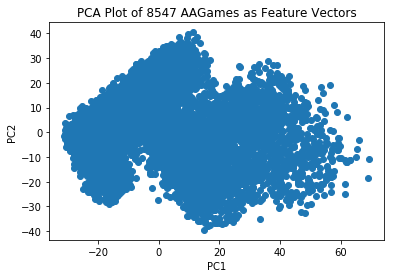

In [150]:
pca = PCA(n_components=2)
X_trainaa_pca = pca.fit_transform(agg_agg_fvset)

plt.plot(X_trainaa_pca[:, 0], X_trainaa_pca[:, 1], 'o')
plt.title('PCA Plot of 8547 AAGames as Feature Vectors')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig(pcaaa_output)
plt.show()

In [ ]:
#aa_rr_minturns = get_games_min_num_turns(aa_rr)
#fv_aa_rr = get_featurevector_gameset(aa_rr_minturns)


pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(fv_aa_rr)

plt.plot(X_train_pca[:, 0], X_train_pca[:, 1], 'o')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
fv_aa_rr

In [ ]:
aa_rr_comps, aa_rr_scaled = get_principal_components(fv_aa_rr)

In [ ]:
aa_rr_comps.sort_values('PC-1-ABS', ascending=False)#.head()

In [ ]:
aa_rr_comps.sort_values('PC-2-ABS', ascending=False).head()

In [ ]:
agg_agg_folders[1]

In [ ]:
aa_rv = get_cleaned_match_df(agg_agg_folders[1])
aa_rv_minturns = get_games_min_num_turns(aa_rv)
fv_aa_rv = get_featurevector_gameset(aa_rv_minturns)
aa_rv_comps, aa_rv_scaled = get_principal_components(fv_aa_rv)
plt.scatter(aa_rv_scaled[:,0], aa_rv_scaled[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
aa_rr_comps.sort_values('PC-1-ABS', ascending=False).head()

In [ ]:
aa_rv_comps.sort_values('PC-1-ABS', ascending=False)#.head()

In [ ]:
agg_agg_folders[2]

In [ ]:
aa_rp = get_cleaned_match_df(agg_agg_folders[1])
aa_rp_minturns = get_games_min_num_turns(aa_rp)
fv_aa_rp = get_featurevector_gameset(aa_rp_minturns)
aa_rp_comps, aa_rp_scaled = get_principal_components(fv_aa_rp)
plt.scatter(aa_rp_scaled[:,0], aa_rp_scaled[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Aggro-Conrol PCA

In [ ]:
agg_con_folders[0]

In [ ]:
ac_ro = get_cleaned_match_df(agg_con_folders[0])
ac_ro_minturns = get_games_min_num_turns(ac_ro)
fv_ac_ro = get_featurevector_gameset(ac_ro_minturns)


pca = PCA(n_components=2)
Xc_train_pca = pca.fit_transform(fv_ac_ro)

plt.plot(Xc_train_pca[:, 0], Xc_train_pca[:, 1], 'o')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()









#ac_ro_comps, ac_ro_scaled = get_principal_components(fv_ac_ro)
#plt.scatter(ac_ro_scaled[:,0], ac_ro_scaled[:,1])
#plt.xlabel('PC1')
#plt.ylabel('PC2')
#plt.show()

# Control-Control PCA

In [128]:
con_con_fvset = get_matchup_featurevectors(con_con_folders, 16, -1)
con_con_fvset.shape

(16089, 1254)

In [142]:
thesis_output ='C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\'
pcacc_output = os.path.join(thesis_output, 'pca-plots\\pcacc.jpg')

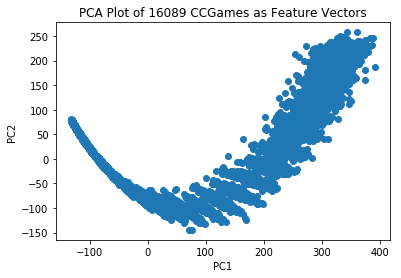

In [149]:
pca = PCA(n_components=2)
X_traincc_pca = pca.fit_transform(con_con_fvset)

plt.plot(X_traincc_pca[:, 0], X_traincc_pca[:, 1], 'o')
plt.title('PCA Plot of 16089 CCGames as Feature Vectors')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig(pcacc_output)
plt.show()

# PCA Over Mirror Matchups

In [129]:
print(agg_agg_fvset.shape, con_con_fvset.shape)

print(agg_agg_fvset.shape[0] + con_con_fvset.shape[0])

(8547, 440) (16089, 1254)
24636


In [131]:
mirror_df = pd.concat([agg_agg_fvset, con_con_fvset], axis=0, sort=False).fillna(-1)
mirror_df.shape

(24636, 1254)

In [146]:
thesis_output ='C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\'
pcam_output = os.path.join(thesis_output, 'pca-plots\\pca-mirrors.jpg')

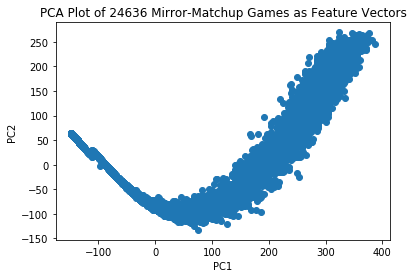

In [148]:
pca = PCA(n_components=2)
X_trainm_pca = pca.fit_transform(mirror_df)

plt.plot(X_trainm_pca[:, 0], X_trainm_pca[:, 1], 'o')
plt.title('PCA Plot of 24636 Mirror-Matchup Games as Feature Vectors')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig(pcam_output)
plt.show()

# Aggro-Aggro Histograms of the Frequency of the Number of Turns

Note the histograms are saved to local folders

In [ ]:
d_ = generate_histograms_score_matchup(agg_agg, 'Aggro-Aggro')

In [ ]:
d_.keys()

In [ ]:
find_num_turn_outliers(d_)

In [ ]:
agg_agg_wins = get_matchups_winrates(agg_agg, ngames=390)

In [ ]:
aa_wr_df = get_winrates_for_matchup_asframe(agg_agg_wins)
aa_wr_df

In [ ]:
aa_wr_arr = aa_wr_df.values.reshape(25, 1)
aa_wr_arr

#### The below cells are for getting Aggro-Control Histograms of the Frequency of the Number of Turns

Note the histograms are saved to local folders

In [ ]:
d_ac = generate_histograms_score_matchup(agg_con, 'Aggro-Control')

In [ ]:
agg_con_wins = get_matchups_winrates(agg_con, ngames=390)

In [ ]:
agg_agg_matchups_arr = np.array(  ['{}{}'.format(m.split('-')[0][:2], m.split('-')[1][:2]) for m in list(agg_agg_wins.keys())] )
agg_con_matchups_arr = np.array(  ['{}{}'.format(m.split('-')[0][:2], m.split('-')[1][:2]) for m in list(agg_con_wins.keys())] )

In [ ]:
ac_wrdf = get_winrates_for_matchup_asframe(agg_con_wins)
ac_wrdf

In [ ]:
ac_wr_arr = ac_wrdf.values.reshape(25,1)
ac_wr_arr

In [ ]:
plt.figure(figsize=(12,3))
plt.subplot(121)
#plt.plot(np.arange(0,1, 0.04), aa_wr_arr, 'o', color='red', label='Agg-Agg')
plt.plot(agg_agg_matchups_arr, aa_wr_arr, 'o', color='red', label='Agg-Agg')
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 0.8, 0.1))
plt.ylabel('Player 1 (Aggro) Winrate')
plt.subplot(122)
plt.plot(agg_con_matchups_arr, ac_wr_arr, 'o', color='blue', label='Agg-Con')
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 0.8, 0.1))

plt.suptitle('Comparing Winrates for the Matchups Aggro-Aggro (Red) and Aggro-Control (Blue)')
plt.gcf().subplots_adjust(bottom=0.25)
#txt = 'The x-label shows the unique matchups from P1 to P2, where the players\' names are denoted by the first two letters of their name.'
#plt.gcf().text(0.5, -0.2, txt, ha='center')
plt.savefig('C:\\Users\\Main\\Documents\\GitHub\\Sabber_Work_2019F\\thesis-images\\comparing-winrates-base-scores.jpg')
plt.show()

In [ ]:
agg_con_matchups_arr

### Collecting the data for Aggro-Control matchups

In [ ]:
acdf = agg_con.get_all_matchup_summary_data()
acdf

In [ ]:
acdf.loc[('Mean-Num-Turns', 'Roffle-Orasha')]

In [ ]:
mt1 = 'Roffle-Krebs1996'
mt2 = 'Roffle-Wabeka'
mean_dif = diff_in_means(acdf, sdf, mt1, mt2)
samp = samp_stat(acdf, sdf, mt1, mt2, 1.65)
print('mean dif', mean_dif)
print('z*samp_var', samp)

# Making CMA-ME Heatmaps

In [18]:
strategy_dir = 'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\StrategySearchResults\\'

In [21]:
indiv_log = os.path.join(strategy_dir, 'Warlock_Net_AA_sm\\logs\\individual_log.csv')
indiv_log

'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\StrategySearchResults\\Warlock_Net_AA_sm\\logs\\individual_log.csv'

In [31]:
help(cma_me_ann_heatmap)

Help on function cma_me_ann_heatmap in module __main__:

cma_me_ann_heatmap(hm_d)
    ann_file = hm_d.get('Individual-Logs')
    strat1 = hm_d['Strat-1']
    strat2 = hm_d['Strat-2']
    ppath = hm_d.get('Output-Folder')
    ngames = hm_d.get('NGames', 100) #Num Games each ANN played



In [32]:
cmame_outputdir = 'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\cmame-plots\\'

Saved heatmap to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\cmame-plots\CMA-ME-Aggro-Aggro-5003x100.jpg


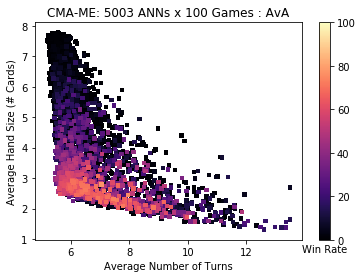

In [39]:
cma_me_ann_heatmap(
    {
        'Individual-Logs':indiv_log,
        'Strat-1':'Aggro',
        'Strat-2':'Aggro',
        'Output-Folder':cmame_outputdir
    }
)

Saved heatmap to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\cmame-plots\CMA-ME-Control-Control-5000x100.jpg


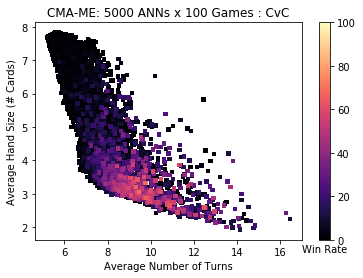

In [40]:
cma_me_ann_heatmap(
    {
        'Individual-Logs':os.path.join(strategy_dir, 'Warlock_Net_CC_sm\\logs\\individual_log.csv'),
        'Strat-1':'Control',
        'Strat-2':'Control',
        'Output-Folder':cmame_outputdir
    }
)

Saved heatmap to C:\Users\watson\Documents\GitHub\SabberStone-master\Sabber_Work_2019F\thesis-output\cmame-plots\CMA-ME-Control-Control-5003x100.jpg


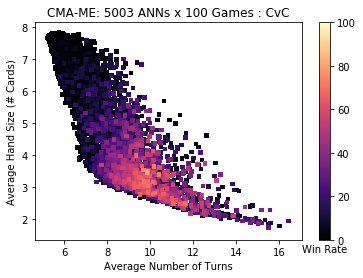

In [41]:
cma_me_ann_heatmap(
    {
        'Individual-Logs':os.path.join(strategy_dir, 'CvsNNC_2.0\\logs\\individual_log.csv'),
        'Strat-1':'Control',
        'Strat-2':'Control',
        'Output-Folder':cmame_outputdir
    }
)

In [ ]:
fig, ax = plt.subplots()
sc = ax.scatter(x, y, c=sub['WinRate'], marker='s', s=20, cmap='magma', vmin=0, vmax=100, edgecolors="none")
plt.xlabel('Average Number of Turns')
plt.ylabel('Average Hand Size')
plt.title('CMA-ME')
plt.colorbar(sc1)
#plt.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=100), cmap='magma'), ax=ax)
plt.show()

# Scratch work to find color palettes

In [ ]:
from seaborn import color_palette
from seaborn import palplot
help(color_palette)

In [ ]:
colorslist = '''Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r'''
colors = colorslist.split(', ')
for c in colors[123:]:
    try:
        palplot(color_palette(c, 20))
    except:
        continue

In [ ]:
print(colors[126:131])